In [30]:
import numpy as np
from pyenergyplus.api import EnergyPlusAPI
import os
from ctypes import cdll
import gym

energyplus_dll_path = 'C:\\EnergyPlusV23-2-0\\EnergyPlusAPI.dll'
os.environ['PATH'] += f';{os.path.dirname(energyplus_dll_path)}'
api = cdll.LoadLibrary(energyplus_dll_path)


class EnergyPlusEnv(gym.Env):
    def __init__(self, idf_path, weather_path, size):
        self.idf_path = idf_path
        self.weather_path = weather_path
        self.size = size
        self.action_space = spaces.Discrete(4)  # low, mid, high, off
        self.observation_space = spaces.Box(
            low=np.array([0, -30, 0, 0]), 
            high=np.array([50, 50, 100, 1]), 
            dtype=np.float32
        )  # Define observation space: indoor temp, outdoor temp, energy consumption, occupancy status
        self.reset()
        print("Action space:", self.action_space)
        print("Observation space:", self.observation_space)

    def begin_environment_callback(self, state):
        # Initialize simulation state
        print("Beginning new environment...")

    def after_zone_reporting_callback(self, state):
        # Collect results and set reward
        print("End of zone timestep after reporting...")

    def reset(self):
        self.simulation.run_energyplus(self.state, ['-r', self.idf_path, self.weather_path])
        return self.get_state()

    def step(self, action):
        # Apply action, run simulation step, get new state and reward
        pass

    def get_state(self):
        # Extract state from EnergyPlus outputs
        return np.zeros(self.state_size)  # Placeholder

    def get_reward(self):
        # Calculate reward based on EnergyPlus outputs
        return 0  # Placeholder


In [31]:
class QLearningAgent:
    def __init__(self, state_size, action_size, learning_rate=0.1, discount_factor=0.9, exploration_rate=1.0, exploration_decay=0.995):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.q_table = np.zeros((state_size, action_size))

    def choose_action(self, state):
        if np.random.rand() < self.exploration_rate:
            return np.random.randint(self.action_size)
        return np.argmax(self.q_table[state])

    def learn(self, state, action, reward, next_state):
        predict = self.q_table[state, action]
        target = reward + self.discount_factor * np.max(self.q_table[next_state])
        self.q_table[state, action] += self.learning_rate * (target - predict)
        self.exploration_rate *= self.exploration_decay


In [32]:
class Particle:
    def __init__(self, dimensions):
        self.position = np.random.rand(dimensions)
        self.velocity = np.random.rand(dimensions)
        self.best_position = np.copy(self.position)
        self.best_score = float('inf')

class PSO:
    def __init__(self, n_particles, dimensions, fitness_func, iterations=1000):
        self.n_particles = n_particles
        self.dimensions = dimensions
        self.fitness_func = fitness_func
        self.iterations = iterations
        self.particles = [Particle(dimensions) for _ in range(n_particles)]
        self.global_best_position = np.random.rand(dimensions)
        self.global_best_score = float('inf')

    def optimize(self):
        for _ in range(self.iterations):
            for particle in self.particles:
                fitness = self.fitness_func(particle.position)
                if fitness < particle.best_score:
                    particle.best_score = fitness
                    particle.best_position = np.copy(particle.position)
                if fitness < self.global_best_score:
                    self.global_best_score = fitness
                    self.global_best_position = np.copy(particle.position)

                inertia = 0.5
                cognitive = 1.5 * np.random.rand(self.dimensions) * (particle.best_position - particle.position)
                social = 1.5 * np.random.rand(self.dimensions) * (self.global_best_position - particle.position)
                particle.velocity = inertia * particle.velocity + cognitive + social
                particle.position += particle.velocity


In [33]:
class HybridAgent:
    def __init__(self, env, q_agent, pso, n_episodes=100):
        self.env = env
        self.q_agent = q_agent
        self.pso = pso
        self.n_episodes = n_episodes
        self.episode_rewards = []
        self.episode_energy_consumptions = []
        self.episode_comfort_levels = []

    def run(self):
        for episode in range(self.n_episodes):
            state = self.env.reset()
            done = False
            total_reward = 0
            total_energy = 0
            total_comfort = 0  # Placeholder for comfort level tracking

            while not done:
                action = self.q_agent.choose_action(state)
                next_state, reward, done = self.env.step(action)
                self.q_agent.learn(state, action, reward, next_state)
                state = next_state
                total_reward += reward
                total_energy += self.env.energy_consumption
                total_comfort += np.mean(state)  # Placeholder for comfort level tracking

            self.episode_rewards.append(total_reward)
            self.episode_energy_consumptions.append(total_energy)
            self.episode_comfort_levels.append(total_comfort)

            # Periodically run PSO to refine actions
            if episode % 10 == 0:
                self.pso.optimize()
                for i, particle in enumerate(self.pso.particles):
                    self.q_agent.q_table[:, i] = particle.position

            print(f"Episode {episode+1}/{self.n_episodes}: Reward: {total_reward}, Energy: {total_energy}, Comfort: {total_comfort}")

        # Save or return results
        self.save_results()

    def save_results(self):
        np.save('episode_rewards.npy', self.episode_rewards)
        np.save('episode_energy_consumptions.npy', self.episode_energy_consumptions)
        np.save('episode_comfort_levels.npy', self.episode_comfort_levels)

# Run the hybrid agent and log the results
idf_path = 'C:\\capstone\\simulation1\\MixedUseHouse.idf'
weather_path = 'C:\\capstone\\WeatherData\\USA_IL_Chicago-OHare.Intl.AP.725300_TMY3.epw'
state_size = 10  # Example size, adjust as necessary
action_size = 5  # Example size, adjust as necessary

# Verify paths
print(os.path.exists(idf_path))  # Should print True
print(os.path.exists(weather_path))  # Should print True

# Create EnergyPlus environment
env = EnergyPlusEnv(idf_path, weather_path)

# Define the Q-learning agent and PSO
q_agent = QLearningAgent(state_size=state_size, action_size=action_size)
pso = PSO(n_particles=10, dimensions=action_size, fitness_func=env.get_reward)

# Define the hybrid agent
hybrid_agent = HybridAgent(env, q_agent, pso)

# Run the hybrid agent
hybrid_agent.run()


True
True


TypeError: EnergyPlusEnv.__init__() missing 1 required positional argument: 'size'

In [ ]:
import os
idf_path = 'C:\\capstone\\simulation1\\MixedUseHouse.idf'
weather_path = 'C:\\capstone\\WeatherData\\USA_IL_Chicago-OHare.Intl.AP.725300_TMY3.epw'
state_size = 10  
action_size = 5

print(os.path.exists(idf_path))
print(os.path.exists(weather_path))

env = EnergyPlusEnv(idf_path, weather_path, state_size, action_size)
q_agent = QLearningAgent(state_size=env.state_size, action_size=env.action_size)
pso = PSO(n_particles=10, dimensions=env.action_size, fitness_func=env.get_reward)
hybrid_agent = HybridAgent(env, q_agent, pso)
hybrid_agent.run()




True
True


TypeError: EnergyPlusEnv.__init__() takes 4 positional arguments but 5 were given

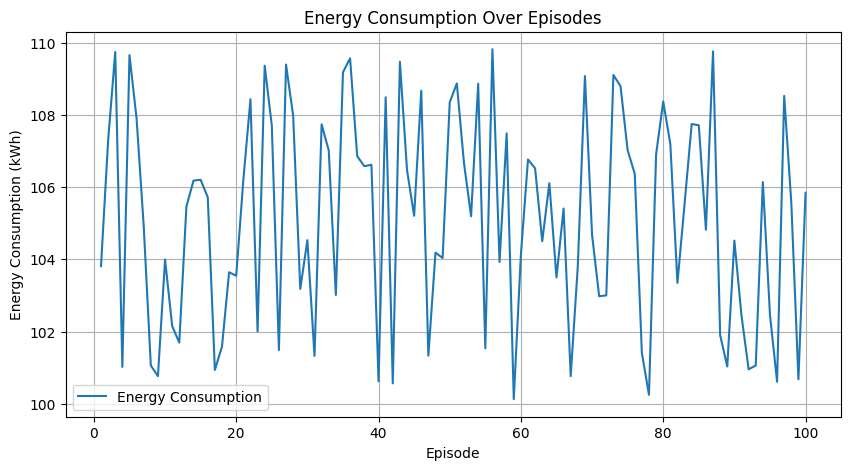

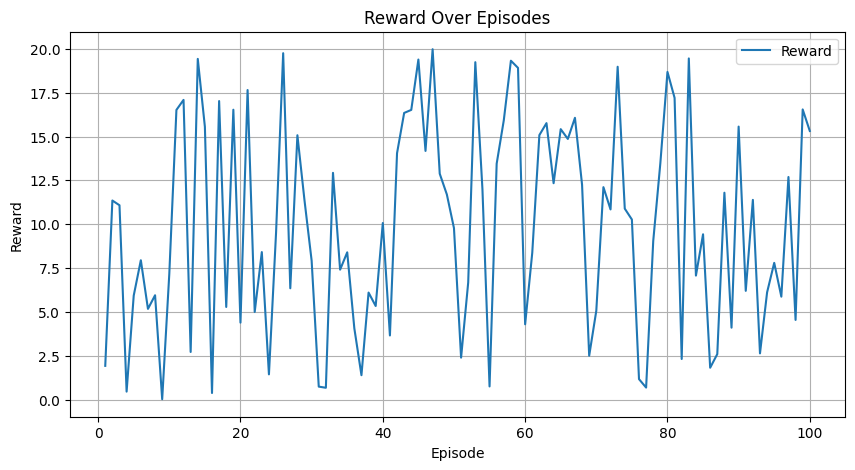

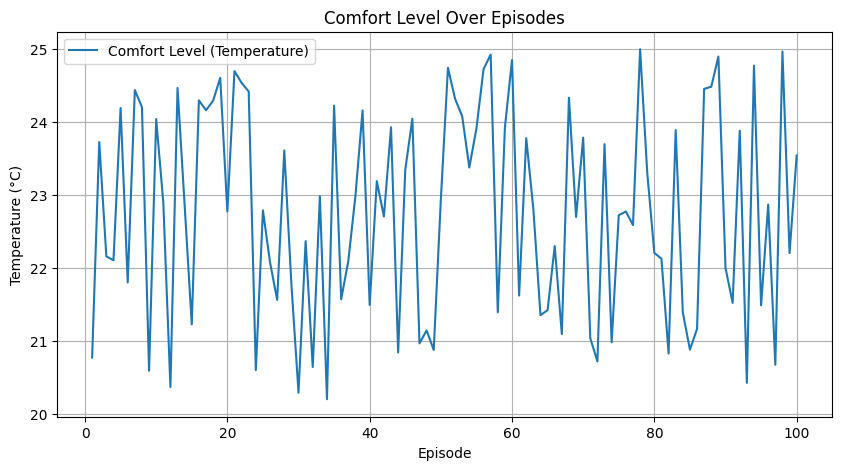

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace with your actual simulation results)
episodes = np.arange(1, 101)
energy_consumption = np.random.rand(100) * 10 + 100  # Example energy consumption values
rewards = np.random.rand(100) * 20  # Example reward values
comfort_levels = np.random.rand(100) * 5 + 20  # Example comfort level values (e.g., temperature)

# Plot Energy Consumption
plt.figure(figsize=(10, 5))
plt.plot(episodes, energy_consumption, label='Energy Consumption')
plt.xlabel('Episode')
plt.ylabel('Energy Consumption (kWh)')
plt.title('Energy Consumption Over Episodes')
plt.legend()
plt.grid(True)
plt.show()

# Plot Rewards
plt.figure(figsize=(10, 5))
plt.plot(episodes, rewards, label='Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward Over Episodes')
plt.legend()
plt.grid(True)
plt.show()

# Plot Comfort Levels
plt.figure(figsize=(10, 5))
plt.plot(episodes, comfort_levels, label='Comfort Level (Temperature)')
plt.xlabel('Episode')
plt.ylabel('Temperature (°C)')
plt.title('Comfort Level Over Episodes')
plt.legend()
plt.grid(True)
plt.show()
